# Exercise 2.11

<p align="justify">
Make a figure analogous to Figure 2.6 for the nonstationary case outlined in Exercise 2.5. Include the constant-step-size $\epsilon$-greedy algorithm with $\alpha = 0.1$. Use runs of 200,000 steps and, as a performance measure for each algorithm and parameter setting, use the average reward over the last 100,000 steps.
</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

from time import time

%matplotlib inline

warnings.filterwarnings('ignore')

### Settings

In [2]:
arms       = 10      # number of "arms" / "bandits"
n_runs     = 100     # number of runs
n_steps    = 200000  # number of steps

actions    = np.arange(arms)  # set of actions

infinity   = 2 ** 30  # "maximum" value

### Functions

In [3]:
def print_results(dct):
    for key in dct.keys():
        print(f'{key:.2f}: {dct[key]:.4f}')
    return

### Simulate random walk

In [4]:
def get_walk(mu=0, sigma=1):
    # simulate a random walk
    return np.random.normal(loc=mu, scale=sigma, size=(n_runs, arms, n_steps))
    

def get_rewards(walk=None, init_value=0):
    if walk is None:
        walk = get_walk()
    return np.ones((n_runs, arms, n_steps)) * init_value + np.cumsum(walk, axis=2)

In [5]:
walk = get_walk(mu=0, sigma=0.01)
rewards = get_rewards(walk)

#### Plot of increments (individual steps of a random walk)

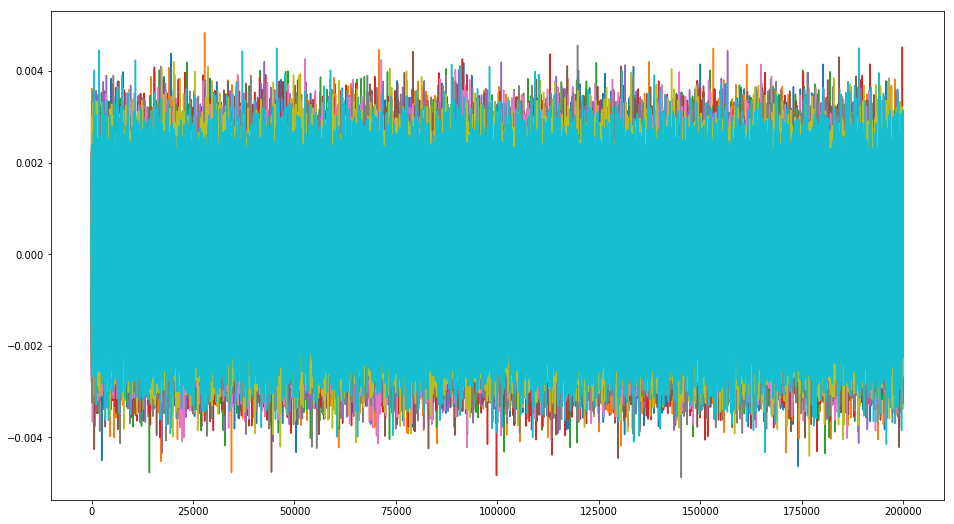

In [6]:
plt.figure(figsize=(16, 9))
plt.plot(np.arange(n_steps), np.mean(walk, axis=0).T)
plt.show()

#### Plot of cumulative rewards

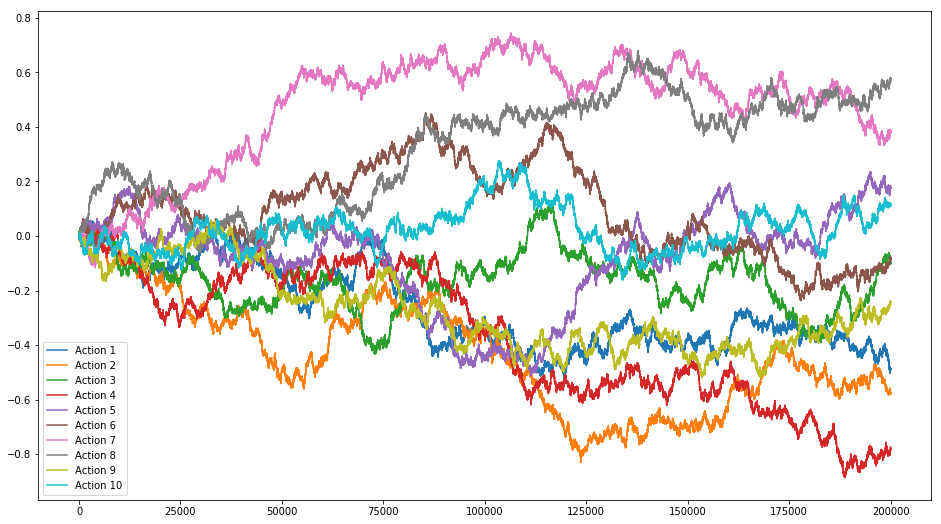

In [7]:
plt.figure(figsize=(16, 9))
plt.plot(np.arange(n_steps), np.mean(rewards, axis=0).T)
plt.legend([f"Action {x}" for x in np.arange(10)+1])
plt.show()

### Incrementally-computed action-value method with constant step-size parameter $\alpha$ (a.k.a. $\epsilon$-greedy)

- $\alpha = 0.1$
- $\epsilon = \{0.01,\ 0.10,\ 0.25,\ 0.50,\ 0.75,\ 0.90\}$

In [8]:
# initialize parameters
alpha    =  0.10                           # step-size parameter (const.)
epsilons = [0.10, 0.25, 0.50, 0.75, 0.90]  # probability of choosing non-greedily

av_results = dict()  # average reward over last 100,000 steps for each variable

for epsilon in epsilons:
    tm = time()
    print(f'Starting simulation with epsilon = {epsilon:.2f}...', end=' ')
    
    av_q = np.zeros((n_runs, arms))  # (sum of rewards) / (number of times)
    av_reward = np.zeros((n_runs, n_steps))  # reward for the action-value method

    for run in range(n_runs):
        for step in range(n_steps):
            # choose an action
            if np.random.uniform() < epsilon:  # exploration
                action = np.random.choice(actions)
            else:  # exploitation
                max_reward = np.argwhere(av_q[run] == np.max(av_q[run]))[:, 0]
                action = np.random.choice(max_reward)  # choose the highest-estimated actions

            # write down the total reward
            av_reward[run, step] = rewards[run, action, step]

            # update estimations
            av_q[run, action] += (rewards[run, action, step] - av_q[run, action]) * alpha
            
    av_results[epsilon] = np.mean(av_reward[:, -100000:])
    print(f'Done in {int(time() - tm)} seconds!')

del(av_q)
del(av_reward)

Starting simulation with epsilon = 0.10... Done in 364 seconds!
Starting simulation with epsilon = 0.25... Done in 319 seconds!
Starting simulation with epsilon = 0.50... Done in 244 seconds!
Starting simulation with epsilon = 0.75... Done in 167 seconds!
Starting simulation with epsilon = 0.90... Done in 120 seconds!


In [9]:
print_results(av_results)

0.10: 5.2522
0.25: 4.3597
0.50: 2.8688
0.75: 1.3813
0.90: 0.4869


### Greedy method with optimistic initialization
- $\alpha = 0.1$
- $\epsilon = 0$
- $Q_{1} = \{0.25,\ 0.50,\ 0.00, 1.00,\ 2.00,\ 4.00\}$

In [10]:
# initialize parameters
alpha =  0.10                           # step-size parameter (const.)
q1s   = [0.25, 0.50, 1.00, 2.00, 4.00]  # initial values of q

oi_results = dict()  # average reward over last 100,000 steps for each variable

for q1 in q1s:
    tm = time()
    print(f'Starting simulation with q1 = {q1:.2f}...', end=' ')
    
    oi_q = np.zeros((n_runs, arms))  # (sum of rewards) / (number of times)
    oi_reward = np.zeros((n_runs, n_steps))  # reward for the action-value method

    oi_q[0, :] = q1  # optimistic initialization of q
    
    for run in range(n_runs):
        for step in range(n_steps):
            max_reward = np.argwhere(oi_q[run] == np.max(oi_q[run]))[:, 0]
            action = np.random.choice(max_reward)  # choose the highest-estimated actions

            # write down the total reward
            oi_reward[run, step] = rewards[run, action, step]

            # update estimations
            oi_q[run, action] += (rewards[run, action, step] - oi_q[run, action]) * alpha
            
    oi_results[q1] = np.mean(oi_reward[:, -100000:])
    print(f'Done in {int(time() - tm)} seconds!')

del(oi_q)
del(oi_reward)

Starting simulation with q1 = 0.25... Done in 372 seconds!
Starting simulation with q1 = 0.50... Done in 371 seconds!
Starting simulation with q1 = 1.00... Done in 367 seconds!
Starting simulation with q1 = 2.00... Done in 369 seconds!
Starting simulation with q1 = 4.00... Done in 373 seconds!


In [11]:
print_results(oi_results)

0.25: 4.4170
0.50: 4.4056
1.00: 4.2483
2.00: 4.7392
4.00: 4.4364


### Upper-confidence-bound (UCB) action selection
- $\alpha = 0.1$
- $\epsilon = 0$
- $c = \{0.25,\ 0.50,\ 1.00,\ 2.00,\ 4.00\}$

$$ A_{t} \doteq \underset{a}{\arg\max} \big[ Q_{t}(a) + c \sqrt{\cfrac{\text{ln}\ t}{N_{t}(a)}} \big]$$

In [12]:
# initialize parameters
alpha =  0.10                           # step-size parameter (const.)
cs    = [0.25, 0.50, 1.00, 2.00, 4.00]  # degrees of exploration

ucb_results = dict()  # average reward over last 100,000 steps for each variable

for c in cs:
    tm = time()
    print(f'Starting simulation with c = {c:.2f}...', end=' ')
    
    ucb_counter = np.zeros((n_runs, arms))  # number of times a taken prior to t
    ucb_q = np.zeros((n_runs, arms))  # (sum of rewards) / (number of times)
    ucb_reward = np.zeros((n_runs, n_steps))  # reward for the action-value method

    for run in range(n_runs):
        for step in range(n_steps):
            potentials = ucb_q[run, :] + c * np.sqrt(np.log(step+1) / ucb_counter[run, :])
            potentials = np.where(np.isnan(potentials), infinity, potentials)
            max_reward = np.argwhere(potentials == np.max(potentials))[:, 0]
            action = np.random.choice(max_reward)  # choose the highest-estimated actions

            # write down the total rewardb
            ucb_reward[run, step] = rewards[run, action, step]

            # update estimations
            ucb_counter[run, action] += 1
            ucb_q[run, action] += (rewards[run, action, step] - ucb_q[run, action]) * alpha
            
    ucb_results[c] = np.mean(ucb_reward[:, -100000:])
    print(f'Done in {int(time() - tm)} seconds!')

del(ucb_counter)
del(ucb_q)
del(ucb_reward)

Starting simulation with c = 0.25... Done in 650 seconds!
Starting simulation with c = 0.50... Done in 639 seconds!
Starting simulation with c = 1.00... Done in 642 seconds!
Starting simulation with c = 2.00... Done in 644 seconds!
Starting simulation with c = 4.00... Done in 642 seconds!


In [13]:
print_results(ucb_results)

0.25: 4.4514
0.50: 4.5893
1.00: 4.5888
2.00: 4.5044
4.00: 4.8010


### Gradient bandit
- $\alpha = \{0.10,\ 0.25,\ 0.50,\ 0.75,\ 0.90\}$

Probability of taking action at time $t$:
$$ \text{Pr}\{A_{t} = a\} \doteq \cfrac{e^{H_{t}(a)}}{\sum_{b=1}^k e^{H_{t}(b)}} \doteq \pi_{t}(a)$$

Preference for a chosen action $A$ at time $t$:
$$ H_{t+1}(A_{t}) \doteq H_{t}(A_{t}) + \alpha (R_{t} - \bar{R}_{t})(1 - \pi_{t}(A_{t})) $$

Preference for all other actions $a$ not chosen at time $t$:
$$ H_{t+1}(a) \doteq H_{t}(a) + \alpha (R_{t} - \bar{R}_{t})(1 - \pi_{t}(a)) $$

In [14]:
# initialize parameters
alphas = [0.10, 0.25, 0.50, 0.75, 0.90]  # step-size parameter (const.)

gb_results = dict()  # average reward over last 100,000 steps for each variable

for alpha in alphas:
    tm = time()
    print(f'Starting simulation with alpha = {alpha:.2f}...', end=' ')
    
    gb_h = np.zeros((n_runs, arms))  # (sum of rewards) / (number of times)
    gb_reward = np.zeros((n_runs, n_steps))  # reward for the action-value method

    for run in range(n_runs):
        for step in range(n_steps):
            probs = np.exp(gb_h[run, :]) / np.sum(np.exp(gb_h[run, :]))  # soft-max probabilities
            max_reward = np.argwhere(probs == np.max(probs))[:, 0]
            action = np.random.choice(max_reward)  # choose the highest-estimated actions
            others = list(set(actions).difference([action]))

            # write down the total rewardb
            gb_reward[run, step] = rewards[run, action, step]
            
            # calculate average of all the reward
            avg_reward = np.mean(gb_reward[run, :step])
            if step == 0:  # no average is available in the first step
                avg_reward = np.where(np.isnan(avg_reward), 0, avg_reward)
            
            # update estimations
            gb_h[run, action] += (rewards[run, action, step] - avg_reward) * (1 - probs[action]) * alpha
            gb_h[run, others] -= (rewards[run, action, step] - avg_reward) * probs[others] * alpha
                
    gb_results[alpha] = np.mean(gb_reward[:, -100000:])
    print(f'Done in {int(time() - tm)} seconds!')

del(gb_h)
del(gb_reward)

Starting simulation with alpha = 0.10... Done in 2080 seconds!
Starting simulation with alpha = 0.25... Done in 2106 seconds!
Starting simulation with alpha = 0.50... Done in 2094 seconds!
Starting simulation with alpha = 0.75... Done in 2082 seconds!
Starting simulation with alpha = 0.90... Done in 2080 seconds!


In [15]:
print_results(gb_results)

0.10: 4.2882
0.25: 4.1872
0.50: 4.2550
0.75: 4.3089
0.90: 4.1565


### Parameter study

In [16]:
def dict_to_list(dct):
    keys = sorted(list(dct.keys()))
    values = [dct[key] for key in keys]
    return keys, values  # returns sorted keys and values

In [17]:
ticks = sorted(list(set(epsilons + q1s + cs + alphas)))
ticks

[0.1, 0.25, 0.5, 0.75, 0.9, 1.0, 2.0, 4.0]

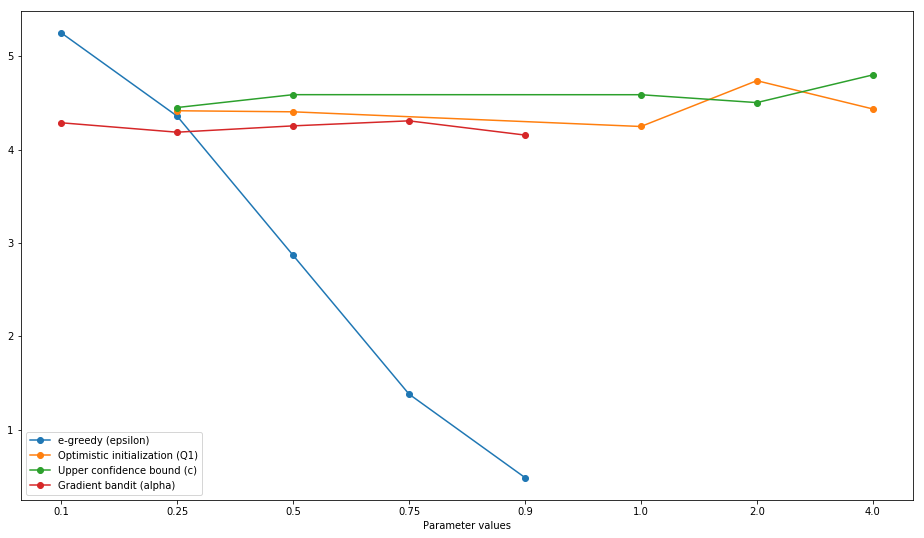

In [18]:
plt.figure(figsize=(16, 9))

av_plot = dict_to_list(av_results)
plt.plot(list(map(ticks.index, av_plot[0])), av_plot[1], '-o')

oi_plot = dict_to_list(oi_results)
plt.plot(list(map(ticks.index, oi_plot[0])), oi_plot[1], '-o')

ucb_plot = dict_to_list(ucb_results)
plt.plot(list(map(ticks.index, ucb_plot[0])), ucb_plot[1], '-o')

gb_plot = dict_to_list(gb_results)
plt.plot(list(map(ticks.index, gb_plot[0])), gb_plot[1], '-o')

plt.xlabel('Parameter values')
plt.ylabel('')
plt.legend(['e-greedy (epsilon)', 'Optimistic initialization (Q1)',
            'Upper confidence bound (c)', 'Gradient bandit (alpha)'])
plt.xticks(np.arange(len(ticks)), ticks)

plt.show()